The idea is to use radial basis functions (RBF) to generate an intensity function for an inhomogeneous Poisson process. We can use a radial basis function, $\phi(t, \theta)$ with parameters $\theta$, the intensity by including weights

$$\lambda(t) = \sum_{m=1}^M w_m \phi(t, \theta_m)$$

For simplicity, I'll choose a gaussian RBF,

$$ \phi(t, t_0, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}}
                     \exp\left(-\frac{(t - t_0)^2}{2\sigma^2}\right) $$

The likelihood function for an inhomogeneous poisson process is 

$$ p(N | \lambda(t)) = \exp\left(-\int_0^T \lambda(t)\, dt\right) \prod_{i=1}^N \lambda(t_i) $$

where $t_i$ is the time of each of the N events. Since our intensity $\lambda(t)$ is modeled as a sum of nomalized RBFs, the integral simply becomes 

$$ \int_0^T \lambda(t)\, dt = \sum_{m=1}^M w_m $$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

First I'll use the RBF model to generate some fake data.

In [2]:
radial_f = lambda x, loc, sig: sp.stats.norm.pdf(x, loc=loc, scale=sig)
def intensity(x, w, loc, sig, radial_func):
    return np.sum([wi*radial_func(x, li, si) 
                   for wi, li, si in zip(w, loc, sig)], axis=0)

In [3]:
# Calculate intensity
x = np.linspace(-1,1,num=200)
weights = [3, 2, 5, 3, 2]
locs = [-1, -0.5, 0, .5, 1]
bandwidths = [0.2]*5
true_lam = intensity(x, weights, locs, bandwidths, radial_f)

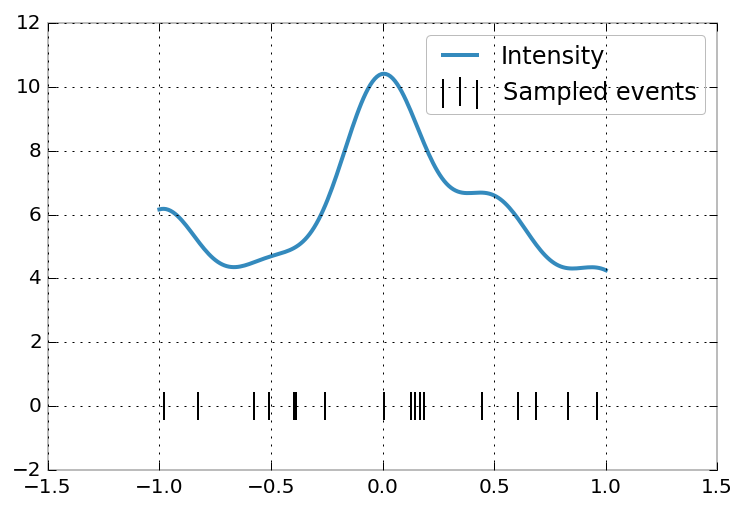

In [4]:
# Sample number of events
N = sp.stats.poisson(np.sum(weights)).rvs()
# Sample locations of N events
dist = sp.stats.rv_discrete(values=(range(len(x)), true_lam/sum(true_lam)))
events = x[dist.rvs(size=N)]
events.sort()

plt.plot(x, true_lam, label="Intensity")
plt.scatter(events, np.zeros(N), color='k', marker='|', s=200, linewidths=1, label="Sampled events")
plt.legend()

Now I want to build a model to infer $\lambda(t)$ from data. I'm using [PyMC3](https://github.com/pymc-devs/pymc3) to build the model and sample from the posterior. These aren't the final priors, just a start.

In [5]:
import pymc3 as pm
from pymc3.distributions import Continuous
import theano
import theano.tensor as T

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
def radial_gaussian(x, loc, sig):
    return T.exp(-(x - loc)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi))
    
def intensity(x, weights, centers, bandwidths):
    rbfs, updates = theano.map(lambda w, loc, sig, x: w*radial_gaussian(x, loc, sig),
                               [weights, centers, bandwidths],
                               non_sequences=x)
    return T.sum(rbfs)
    
class PoissonRBF(Continuous):
    def __init__(self, weights, centers, bandwidths, *args, **kwargs):
        super(PoissonRBF, self).__init__(*args, **kwargs)
        self.weights = weights
        self.centers = centers
        self.bandwidths = bandwidths
        
    def logp(self, values):
        lam_t, updates = theano.map(lambda t, ws, locs, bws: intensity(t, ws, locs, bws),
                                    values,
                                    non_sequences=[self.weights, self.centers, self.bandwidths])
        return -T.sum(self.weights) + T.sum(T.log(lam_t))

with pm.Model() as model:
    # Use five RBFs
    basis_D = 5
    
    # Define priors here...
    weights = pm.Exponential('weights', .1, shape=(basis_D,))
    centers = pm.Uniform('centers', -1, 1, shape=(basis_D,))
    bandwidths = pm.Uniform('bandwidths', 0.05, 0.5, shape=(basis_D))
    
    likelihood = PoissonRBF("obs", weights, centers, bandwidths, observed=events)

The Metropolis sampler is working here, Slice and NUTS don't seem to.

In [8]:
with model:
    start = pm.find_MAP(vars=[weights, centers, bandwidths])
    step = pm.Metropolis()
    trace = pm.sample(30000, step, start=start)

 [-----------------100%-----------------] 30000 of 30000 complete in 42.6 sec

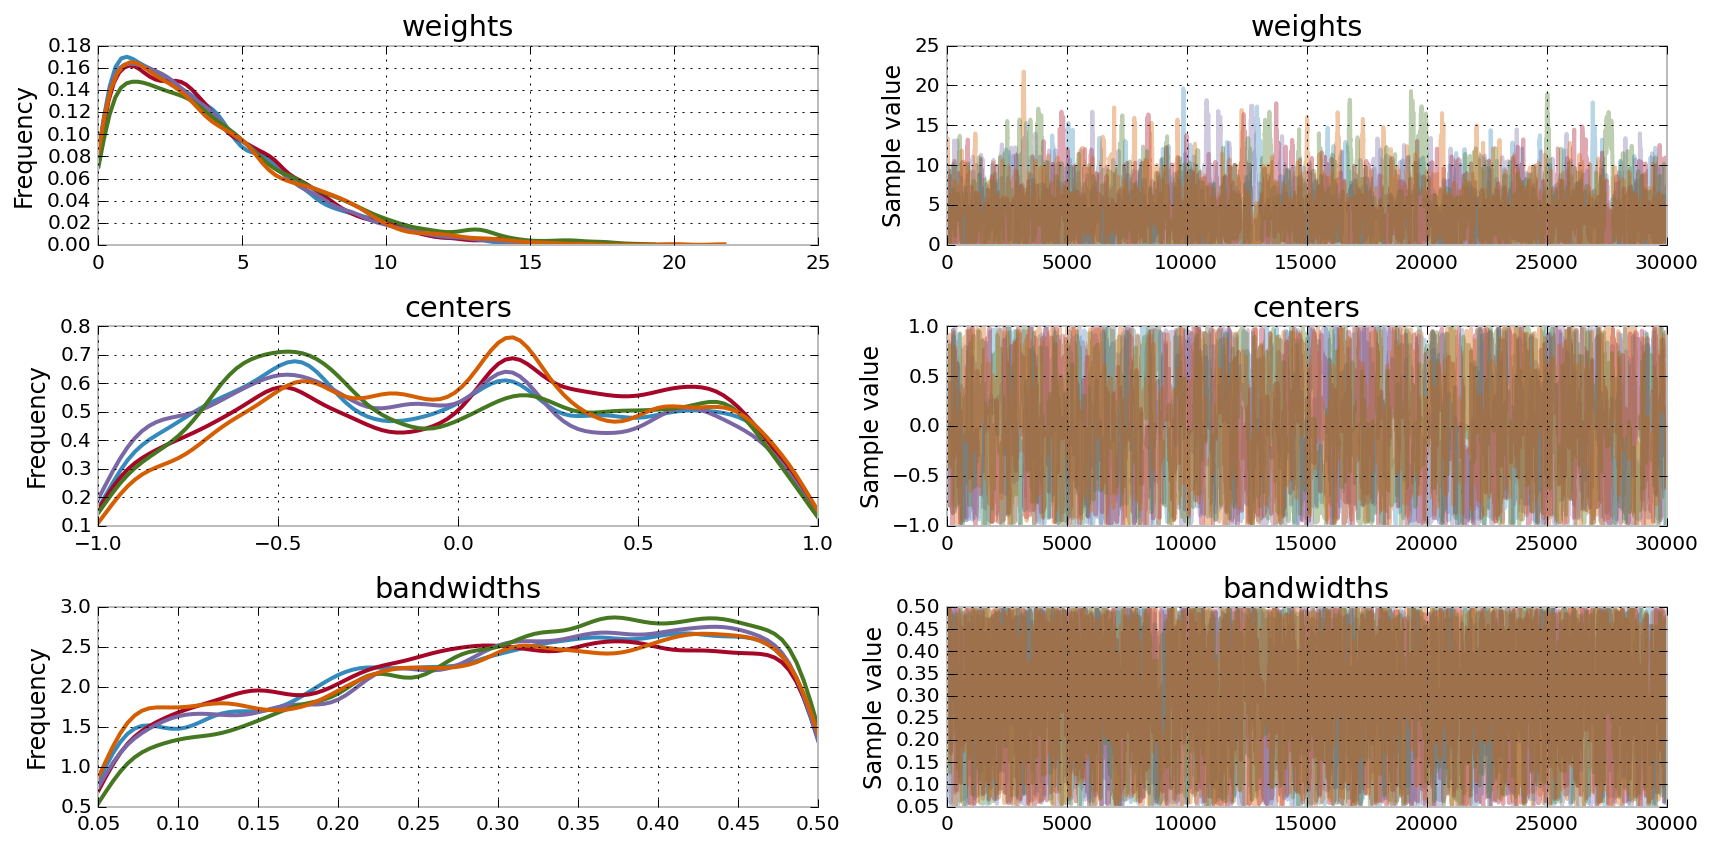

In [9]:
fig = pm.plots.traceplot(trace)

In [10]:
# Burn 10000 samples and thin by 5
pruned_trace = trace[10000::5]
x = np.linspace(-1,1,num=200)
ws = pruned_trace['weights']
locs = pruned_trace['centers']
bws = pruned_trace['bandwidths']

radial_f = lambda r, loc, sig: sp.stats.norm.pdf(r, loc=loc, scale=sig)
def realization(x, ws, locs, bws):
    f = lambda w, loc, bw: w*radial_f(x, loc, bw)
    return np.sum(map(f, ws, locs, bws), axis=0)

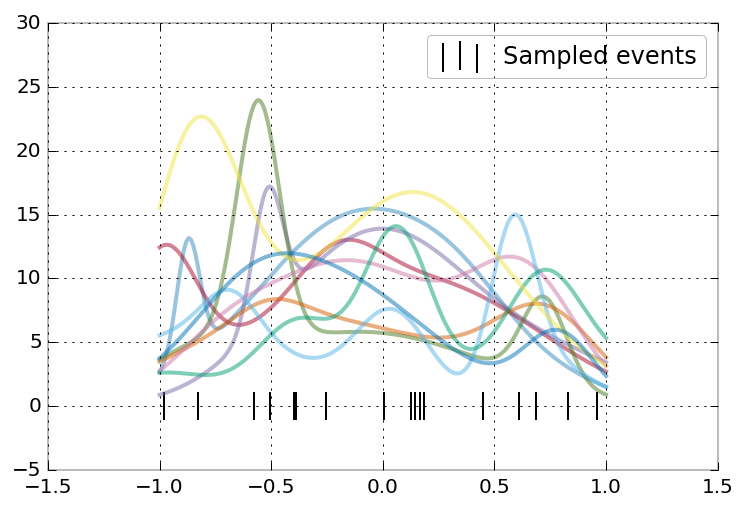

In [11]:
for i in np.random.choice(np.arange(len(ws)), size=10):
    lam = realization(x, ws[i], locs[i], bws[i])
    plt.plot(x, lam, alpha=0.5)

plt.scatter(events, np.zeros(N), color='k', marker='|', s=200, linewidths=1, label="Sampled events")
plt.legend()

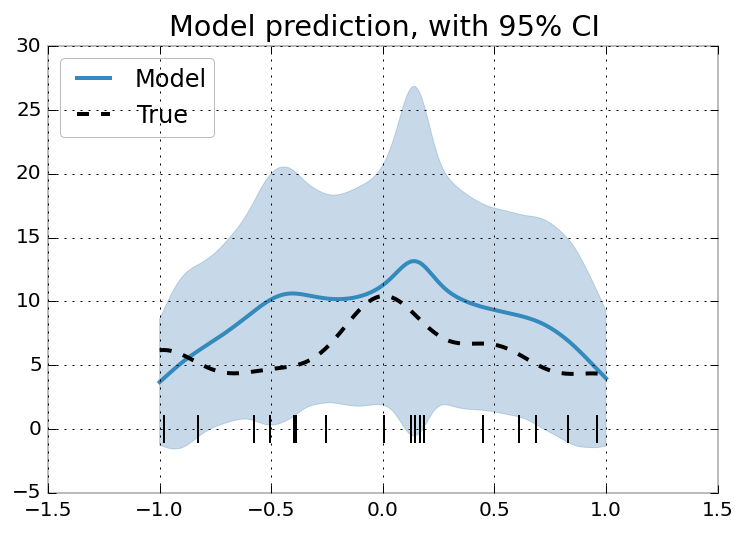

In [12]:
realizations = map(lambda w, l, b: realization(x, w, l, b), ws, locs, bws)
mean_lam = np.mean(realizations, axis=0)
stds = np.std(realizations, axis=0)

plt.title('Model prediction, with 95% CI')
plt.plot(x, mean_lam, label='Model')
plt.fill_between(x, mean_lam-1.96*stds, mean_lam+1.96*stds, color='steelblue', alpha=0.3) 
plt.plot(x, true_lam, '--k', label='True')
plt.scatter(events, np.zeros(N), color='k', marker='|', s=200, linewidths=1)
plt.legend(loc='upper left')

Some things I've found:
* Putting a prior on RBF locations seems to work well. But I can imagine fixing them in place might work well too.
* If the bandwidths are allowed to go to zero, sometimes an RBF will land on top of an event and it'll become a very narrow, very tall spike